# Convert CAN packets to binary CAN Frames

* Preparatory work
* Later read all the CAN packets and convert them to one large file

* TODO: binary representation of CAN frame does not fit to measurement

* Created with friendly help of `deepseek` 

In [117]:
from scapy.layers.can import CAN
from matplotlib import pyplot as plt
import pandas as pd

## Manually parse a line from the measurement

In [118]:
line = ' (1738335291.318676)  can1  246   [7]  4A 2A 6C 29 D5 30 4D'
# line = ' (1738335291.365337)  can1  387   [1]  64'
# line = ' (1738335291.931681)  can1  0AF   [8]  A8 77 58 16 96 9A 1C 1E'

# line = ' (1738335291.318676)  can1  123   [8]  01 02 03 04 05 06 07'

In [119]:
# parse the line 
print(f'line: {line}')

array_split = line.split() 
# print(f'array_split: {array_split}')

# extract timestamp
timestamp_str = array_split[0][1:-1]
print(f'timestamp_str: {timestamp_str}')
ts = float(timestamp_str)
print(f'ts: {ts}')

# CAN id
can_id_str = array_split[2]
print(f'can_id_str: {can_id_str}')

can_length = int(array_split[3][1:-1])
print(f'can_length: {can_length}')

# payload
payload_str = line.split('[', 1)[-1].split(']',1)[1].replace(' ','').strip()
print(f'payload_str: {payload_str}')

line:  (1738335291.318676)  can1  246   [7]  4A 2A 6C 29 D5 30 4D
timestamp_str: 1738335291.318676
ts: 1738335291.318676
can_id_str: 246
can_length: 7
payload_str: 4A2A6C29D5304D


In [120]:
# create CAN packet
pkt = CAN(identifier=int(can_id_str, 16), length=can_length, data=bytes.fromhex(payload_str))
# 
print(f'pkt: {pkt}')
print(f'pkt.data: {pkt.data}')
print(f'pkt.identifier: {pkt.identifier}')

pkt.show()

pkt: CAN
pkt.data: b'J*l)\xd50M'
pkt.identifier: 582
###[ CAN ]###
  flags     = 
  identifier= 0x246
  length    = 7
  reserved  = 0
  data      = b'J*l)\xd50M'



## Create binary representation

In [121]:
def calculate_crc(bits):
    data_bytes = int(bits, 2).to_bytes((len(bits) + 7) // 8, 'big')
    crc = 0
    for byte in data_bytes:
        crc ^= byte << 7
        for _ in range(8):
            crc <<= 1
            if crc & 0x8000:
                crc ^= 0xc599
    return crc & 0x7fff


In [122]:
def bit_stuff(bits):
    stuffed = []
    for bit in bits:
        if len(stuffed) > 4:
            if stuffed[-5:] == ['0','0','0','0','0']:
                stuffed.append('1')
            elif stuffed[-5:] == ['1','1','1','1','1']:
                stuffed.append('0')
        stuffed.append(bit)
    return stuffed


In [133]:
def frame_to_bits(pkt):
    # Base frame: SOF, ID, Control, Data
    base = [
        '0',  # SOF
        f"{pkt.identifier:011b}",  # 11-bit ID (MSB first)
        '0' + '0' + '0' + f"{pkt.length:04b}",  # Control field
        ''.join(f"{b:08b}" for b in pkt.data)  # Data bytes
    ]
    bits = ''.join(base)
    
    # Compute CRC and append
    crc = compute_crc(bits)
    bits += f"{crc:015b}"
    
    # Bit stuffing
    stuffed = bit_stuff(bits)
    
    # Frame end components
    return stuffed + ['1']*3 + ['1']*7  # CRC delim + ACK + EOF


In [134]:
# convert the CAN packet to bits
bits = frame_to_bits(pkt)
# convert the bits to integers
bits = [int(b) for b in bits]

print(bits)

[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [135]:
# add a single 0 at the beginning of the bits
# DEBUG: use this to fill in some data in front of the package

# bits = [0] + bits

In [137]:
# DEBUG: print the bits as string
# create string of bits
''.join(f"{b}" for b in bits)

'001001000110000011110100101000101010011011000010100111010101001100000110011011010010001111001111111111'

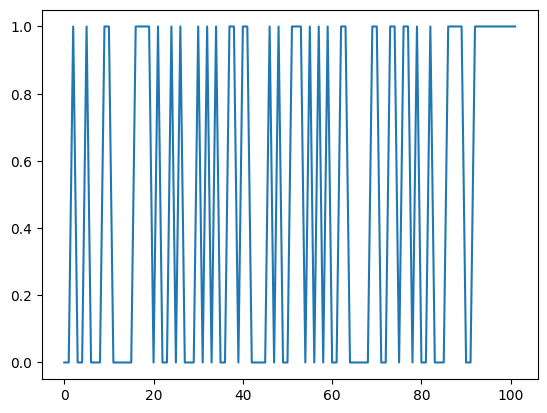

In [138]:
# DEBUG: plot the bits
plt.plot(bits)
plt.show()

## Create file with bits and timestamp

In [151]:
TIME_STEP = 2e-6 # 2 microseconds per bit, i.e., 500000 bits per second

In [152]:
times = [ts + i * TIME_STEP for i in range(len(bits))]

In [153]:
# DEBUG: plot the created timestamps
# times

In [154]:
# Create DataFrame
df_bits = pd.DataFrame({
    'time': times,
    'bit': bits
})

In [155]:
# DEBUG: check created DataFrame
df_bits.head()

,time,bit
0,1.738335e+09,0
1,1.738335e+09,0
2,1.738335e+09,1
3,1.738335e+09,0
4,1.738335e+09,0


In [156]:
# DEBUG
df_bits.iloc[0]

time    1.738335e+09
bit     0.000000e+00
Name: 0, dtype: float64

<Axes: xlabel='time'>

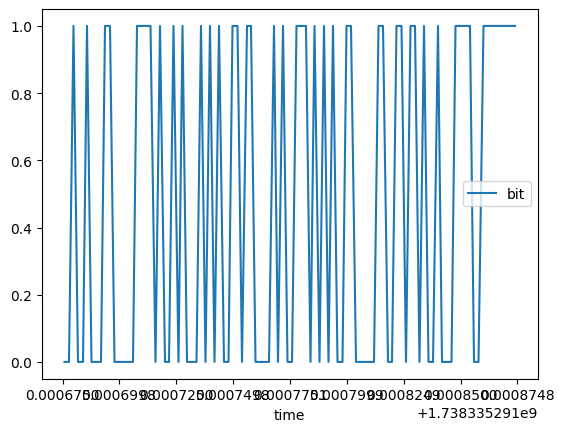

In [157]:
# DEBUG: plot dataframe with time and bit
df_bits[:100].plot(x=0, y=1)

## Save the data

In [158]:
# Save to CSV
df_bits.to_csv('../data/can_bits.csv', index=False, header=False, sep=';')